<a href="https://colab.research.google.com/github/MikaelaTR/Fake-search-algorithm/blob/main/neiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kornia
!pip install kornia-moons
!pip install opencv-python
!pip install matplotlib
!pip install torch
!pip install torchvision
!pip instal PIllow

/usr/local/lib/python3.8/dist-packages/kornia/feature/loftr/utils/coarse_matching.py:243: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  mkpts0_c = torch.stack([i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]], dim=1) * scale0
/usr/local/lib/python3.8/dist-packages/kornia/feature/loftr/utils/coarse_matching.py:244: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a,

keypoints0
keypoints1
confidence
batch_indexes


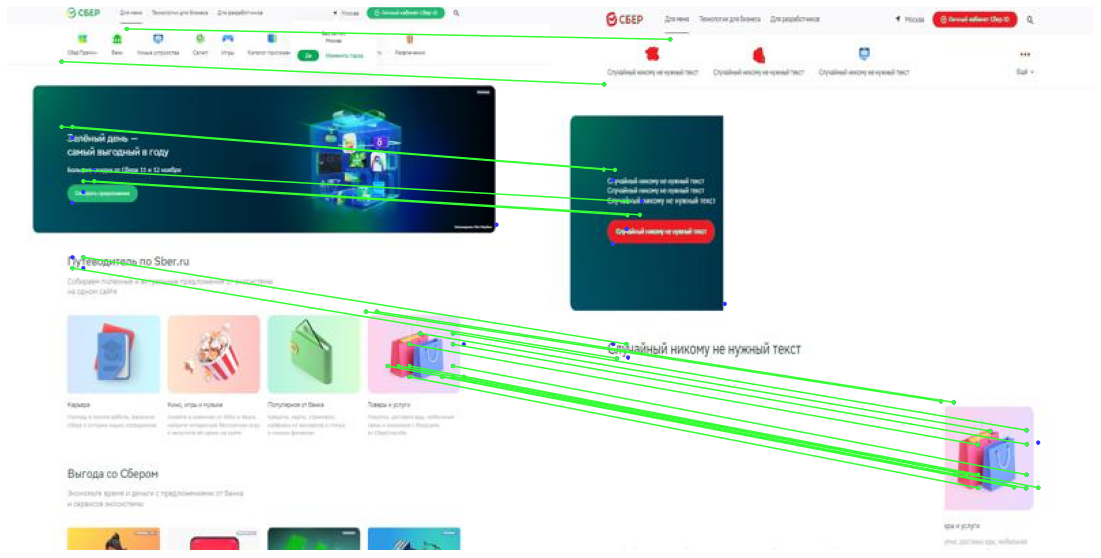

31  - Число общих точек
18 - результат сравнения по хешу
Процент схожести  по пикселям: 41%


In [40]:
import matplotlib.pyplot as plt
import cv2
import kornia as K
import kornia.feature as KF
import numpy as np
import torch
from kornia_moons.feature import *
import torchvision
from PIL import Image
import math
calc=1
i=0
j=0

def load_torch_image(fname):
    img = K.image_to_tensor(cv2.imread(fname), False).float() / 255
    img = K.color.bgr_to_rgb(img)
    return img
    

image_path ='img1.jpg'
img = Image.open(image_path)
new_image = img.resize((400, 400))
new_image.show()
new_image.save('img1rez.jpg')
fname1 = 'img1rez.jpg'
image_path ='img2.jpg'
img = Image.open(image_path)
new_image = img.resize((400,400))
new_image.show()
new_image.save('img2rez.jpg')
fname2 = 'img2rez.jpg'

img1 = load_torch_image(fname1)
img2 = load_torch_image(fname2)

matcher = KF.LoFTR(pretrained='outdoor')

input_dict = {'image0': K.color.rgb_to_grayscale(img1),
              'image1': K.color.rgb_to_grayscale(img2)}

with torch.no_grad():
    correspondences = matcher(input_dict)

for k, v in correspondences.items():
    print(k)

mask = correspondences['confidence'] > 0.9
indices = torch.nonzero(mask)
correspondences['confidence'] = correspondences['confidence'][indices]
correspondences['keypoints0'] = correspondences['keypoints0'][indices]
correspondences['keypoints1'] = correspondences['keypoints1'][indices]
correspondences['batch_indexes'] = correspondences['batch_indexes'][indices]

mkpts0 = correspondences['keypoints0'].cpu().numpy()
mkpts1 = correspondences['keypoints1'].cpu().numpy()
H, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000,)
inliers = inliers > 0


#Функция отрисовки совпадений
draw_LAF_matches(
    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1)),

    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
    torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={'inlier_color': (0.2, 1, 0.2),
               'tentative_color': None,
               'feature_color': (0.2, 0.2, 1), 'vertical': False})

plt.axis('off')
plt.savefig('matches1.png')
plt.show()
list = mkpts0,mkpts1
columns = len(list[0])
print(columns," - Число общих точек")
import cv2
import difflib
from PIL import Image
calc=0
#Функция вычисления хэша
def CalcImageHash(FileName):
    image = cv2.imread(FileName) #Прочитаем картинку
    resized = cv2.resize(image, (40,40), interpolation = cv2.INTER_AREA) #Уменьшим картинку
    gray_image = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY) #Переведем в черно-белый формат
    avg=gray_image.mean() #Среднее значение пикселя
    ret, threshold_image = cv2.threshold(gray_image, avg, 255, 0) #Бинаризация по порогу
    
    #Рассчитаем хэш
    _hash=""
    for x in range(8):
        for y in range(8):
            val=threshold_image[x,y]
            if val==255:
                _hash=_hash+"1"
            else:
                _hash=_hash+"0"
            
    return _hash

def CompareHash(hash1,hash2):
    l=len(hash1)
    i=0
    count=0
    while i<l:
        if hash1[i]!=hash2[i]:
            count=count+1
        i=i+1
    return count       
hash1=CalcImageHash("img1.jpg")
hash2=CalcImageHash("img2.jpg")
calc+=CompareHash(hash1, hash2)
print(calc,"- результат сравнения по хешу")
nimg1 = Image.open("img1.jpg")
img1 = nimg1.resize((3000, 3000))
img1.save('img1-short.jpg', quality=95)
im1 = img1.load() # Загружаем первое изображение для доступа к пикселям
nimg2 = Image.open("img2.jpg")
img2 = nimg2.resize((3000, 3000))
img2.save('img2-short.jpg', quality=95)
im2 = img2.load() # Загружаем первое изображение для доступа к пикселям
p=0
i = 0 # Счетчик пикселей, которые не совпадают

i = 0 # Счетчик пикселей, которые не совпадают

if (img1.size == img2.size): # Проверяем, что размер изображений совпадают
  x1,y1 = img1.size # Через атрибут size получаем кортеж с двумя элементами (размер изображения по x и y)

  # Проходимся последовательно по каждому пикселю картинок
  for x in range(0,x1):
    for y in range(0,y1):
      if im1[x,y] != im2[x,y]: # Если пиксель первой картинки по координатах [x,y] не совпадает
        # с пикселем второй картинки по координатах [x,y], тогда:
        i = i + 1 # Увеличиваем счетчик на 1
        p = p + 1
      else:
        p = p + 1
  vivod2=math.ceil(((p-i)/p)*100)
  print(f"Процент схожести  по пикселям: {vivod2}%")